In [1]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from scipy.stats import spearmanr
from sklearn import preprocessing as pp

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-09-23 13:16:29.006453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [2]:
adata = sc.read("/lustre/groups/ml01/workspace/dominik.klein/cellot_data/hvg.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 762039 × 1000
    obs: 'size_factor', 'cell_type', 'replicate', 'dose', 'drug_code', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'drug', 'drug-dose', 'drug_code-dose', 'n_genes'
    var: 'gene_short_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs', 'marker_genes-drug-rank', 'marker_genes-drug-score'

In [4]:
subset = ["control", "dacinostat", "givinostat", "belinostat", "hesperadin", "quisinostat_2hcl", 'alvespimycin_hcl', "tanespimycin", "tak_901", "flavopiridol_hcl"]

In [5]:
adata_red = sc.concat(
    [adata[adata.obs["drug"]=="control"], adata[adata.obs["drug"]=="givinostat"]],
    join="outer",
    label="drug",
    keys=["control", "givinostat"],
)
#adata_red = adata[adata.obs["drug"].isin(["control", "givinostat"])]

In [6]:
sc.pp.pca(adata_red)
sc.pp.neighbors(adata_red)
sc.tl.umap(adata_red)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


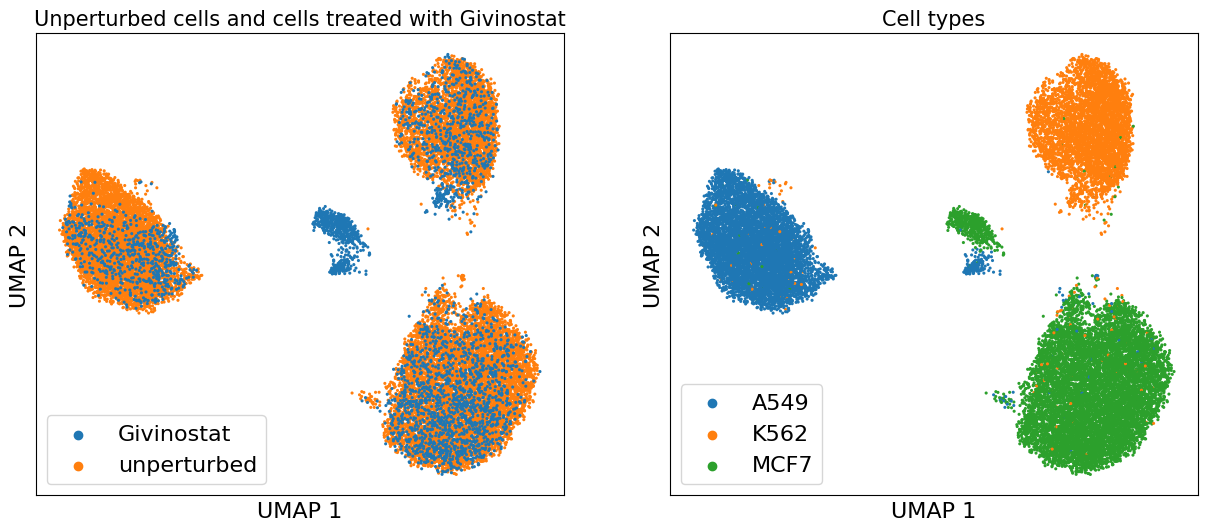

In [7]:
adata_red.obs["drug_renamed"] = adata_red.obs.apply(lambda x: "Givinostat" if x["drug"]=="givinostat" else "unperturbed", axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_red, color=["drug_renamed"], ax=ax1, size=20, show=False)
ax1.set_title(r"Unperturbed cells and cells treated with Givinostat", fontsize=15)
ax1.set_xlabel("UMAP 1", fontsize=16)
ax1.set_ylabel("UMAP 2", fontsize=16)
ax1.legend(fontsize=16, loc="lower left")
sc.pl.umap(adata_red, color=["cell_type"], ax=ax2, size=20, show=False, vmax="p99")
ax2.set_title(r"Cell types", fontsize=15)
ax2.set_xlabel("UMAP 1", fontsize=16)
ax2.set_ylabel("UMAP 2", fontsize=16)
ax2.legend(fontsize=16, loc="lower left")

In [8]:
source = adata_red[adata_red.obs["drug"]=="control"].obsm["X_pca"]
target = adata_red[adata_red.obs["drug"]=="givinostat"].obsm["X_pca"]

In [9]:
ot_solver=ott.solvers.linear.sinkhorn.Sinkhorn()
neural_net = MLP_vector_field(target.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(target.shape[1], 1)

mlp_eta = MLP_marginal(256, 5)
mlp_xi = MLP_marginal(256, 5)

otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver,  mlp_eta=mlp_eta, mlp_xi = mlp_xi, tau_a=0.8, tau_b=0.8, epsilon=5e-2, scale_cost="mean", input_dim=50, output_dim=50, iterations=10_000, k_noise_per_x=1)

2023-09-23 13:17:29.271164: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.128). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
otfm(source, target, 1024, 1024)

100%|██████████| 10000/10000 [01:48<00:00, 91.87it/s]


In [11]:
push_source = [None] * 30

for i in range(30):
    push_source[i] = otfm.transport(source, seed=i)[0][0,...]

In [12]:
adata_pushed = adata_red.copy()
adata_pushed.obsm["X_pca_result"] = np.concatenate((push_source[0], target), axis=0)
adata_pushed.obsm["X_pca_result_cond_mean"] = np.concatenate((jnp.mean(jnp.asarray(push_source), axis=0), target), axis=0)

In [13]:
sc.pp.neighbors(adata_pushed, use_rep="X_pca_result")
sc.tl.umap(adata_pushed)


In [14]:
from typing import Any, Iterable, Tuple

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from joblib import Parallel, delayed


def sample_velocities_from_transport_matrix(
    transport_matrix: np.ndarray, target_distribution: np.ndarray, n_samples: int
) -> np.ndarray:
    res = [None] * n_samples
    for i in range(n_samples):
        res[i] = target_distribution[
            jax.vmap(lambda x: jax.random.categorical(jax.random.PRNGKey(i), x))(jnp.log(transport_matrix))
        ]
    return jnp.asarray(res)


def compute_statistics_from_samples(
    samples: np.ndarray, split_to_k_batches: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    batch_size = samples.shape[0] // split_to_k_batches
    assert samples.shape[0] % split_to_k_batches == 0
    # samples is of shape (n_samples, n_cells, dim_velocity_vector)
    df = pd.DataFrame(index=cell_names)

    for i in range(split_to_k_batches):
        df[f"var_{i}"] = np.sum(np.var(samples[i * batch_size : (i + 1) * batch_size, ...], axis=0), axis=1)
        var_cols = [f"var_{i}" for i in range(split_to_k_batches)]

    df["var_of_variance"] = df[var_cols].var(axis=1)
    df["mean_of_variance"] = df[var_cols].mean(axis=1)
    return df


def compute_directional_statistics_from_samples(
    samples: np.ndarray, n_jobs: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    samples = np.asarray(samples)
    n_cells = len(cell_names)
    df = pd.DataFrame(index=cell_names)
    df["directional_variance"] = np.nan
    df["directional_difference"] = np.nan
    df["directional_cosine_sim_variance"] = np.nan
    df["directional_cosine_sim_difference"] = np.nan
    df["directional_cosine_sim_mean"] = np.nan
    results = Parallel(n_jobs=n_jobs, verbose=3)(
        delayed(_directional_statistics_per_cell)(samples[:, cell_index, :]) for cell_index in range(n_cells)
    )
    # cells by samples
    cosine_sims = np.stack([results[i][0] for i in range(n_cells)])
    df.loc[:, "directional_cosine_sim_variance"] = [results[i][1] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_difference"] = [results[i][2] for i in range(n_cells)]
    df.loc[:, "directional_variance"] = [results[i][3] for i in range(n_cells)]
    df.loc[:, "directional_difference"] = [results[i][4] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_mean"] = [results[i][5] for i in range(n_cells)]

    return df, cosine_sims


def _cosine_sim(v1: np.ndarray, v2: np.ndarray) -> np.ndarray:
    """Returns cosine similarity of the vectors."""
    v1_u = _centered_unit_vector(v1)
    v2_u = _centered_unit_vector(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)


def _directional_statistics_per_cell(
    tensor: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Internal function for parallelization.

    Parameters
    ----------
    tensor
        Shape of samples by genes for a given cell.
    """
    n_samples = tensor.shape[0]
    # over samples axis
    mean_velocity_of_cell = tensor.mean(0)
    cosine_sims = [_cosine_sim(tensor[i, :], mean_velocity_of_cell) for i in range(n_samples)]
    angle_samples = [np.arccos(el) for el in cosine_sims]
    return (
        cosine_sims,
        np.var(cosine_sims),
        np.percentile(cosine_sims, 95) - np.percentile(cosine_sims, 5),
        np.var(angle_samples),
        np.percentile(angle_samples, 95) - np.percentile(angle_samples, 5),
        np.mean(cosine_sims),
    )


def _centered_unit_vector(vector: np.ndarray) -> np.ndarray:
    """Returns the centered unit vector of the vector."""
    vector = vector - np.mean(vector)
    return vector / np.linalg.norm(vector)

In [15]:
cosine_vars_train = compute_directional_statistics_from_samples(push_source, 2, adata_red[adata_red.obs.drug=="control"].obs_names)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 102 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 11526 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done 17565 out of 17565 | elapsed:   15.8s finished


In [16]:
adata_red.obs["directional_cosine_sim_variance"] = cosine_vars_train[0]["directional_cosine_sim_variance"]
adata_pushed.obs["directional_cosine_sim_variance"] = cosine_vars_train[0]["directional_cosine_sim_variance"]

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, 'UMAP 2')

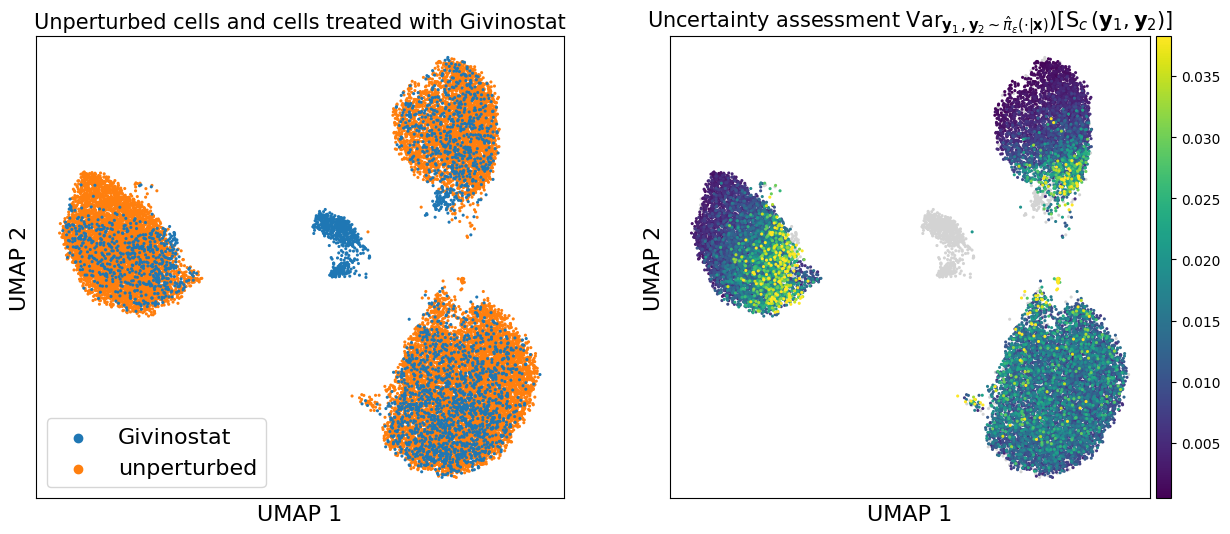

In [17]:
adata_red.obs["drug_renamed"] = adata_red.obs.apply(lambda x: "Givinostat" if x["drug"]=="givinostat" else "unperturbed", axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_red, color=["drug_renamed"], ax=ax1, size=20, show=False)
ax1.set_title(r"Unperturbed cells and cells treated with Givinostat", fontsize=15)
ax1.set_xlabel("UMAP 1", fontsize=16)
ax1.set_ylabel("UMAP 2", fontsize=16)
ax1.legend(fontsize=16, loc="lower left")
sc.pl.umap(adata_red, color=["directional_cosine_sim_variance"], ax=ax2, size=20, show=False, vmax="p99")
ax2.set_title(r"Uncertainty assessment $\operatorname{Var}_{\mathbf{y}_1, \mathbf{y}_2 \sim \hat{\pi}_\varepsilon(\cdot | \mathbf{x})})[\operatorname{S}_c(\mathbf{y}_1, \mathbf{y}_2)]$", fontsize=15)
ax2.set_xlabel("UMAP 1", fontsize=16)
ax2.set_ylabel("UMAP 2", fontsize=16)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, 'UMAP 2')

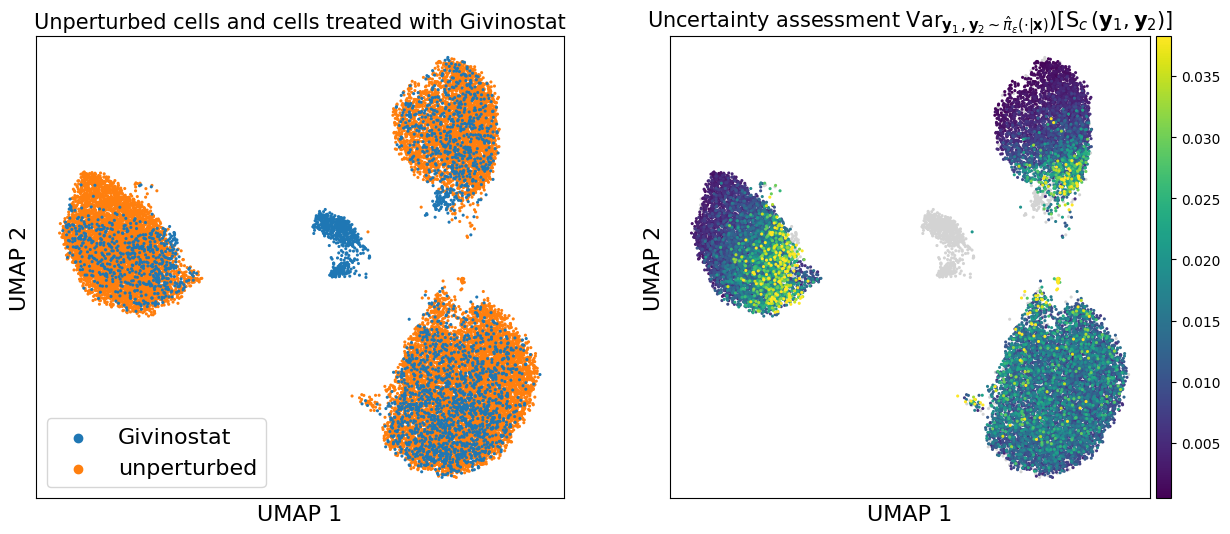

In [18]:
adata_red.obs["drug_renamed"] = adata_red.obs.apply(lambda x: "Givinostat" if x["drug"]=="givinostat" else "unperturbed", axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_red, color=["drug_renamed"], ax=ax1, size=20, show=False)
ax1.set_title(r"Unperturbed cells and cells treated with Givinostat", fontsize=15)
ax1.set_xlabel("UMAP 1", fontsize=16)
ax1.set_ylabel("UMAP 2", fontsize=16)
ax1.legend(fontsize=16, loc="lower left")
sc.pl.umap(adata_red, color=["directional_cosine_sim_variance"], ax=ax2, size=20, show=False, vmax="p99")
ax2.set_title(r"Uncertainty assessment $\operatorname{Var}_{\mathbf{y}_1, \mathbf{y}_2 \sim \hat{\pi}_\varepsilon(\cdot | \mathbf{x})})[\operatorname{S}_c(\mathbf{y}_1, \mathbf{y}_2)]$", fontsize=15)
ax2.set_xlabel("UMAP 1", fontsize=16)
ax2.set_ylabel("UMAP 2", fontsize=16)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Joint UMAP of transported cells and cells in the target distribution'}, xlabel='UMAP 1', ylabel='UMAP 2'>

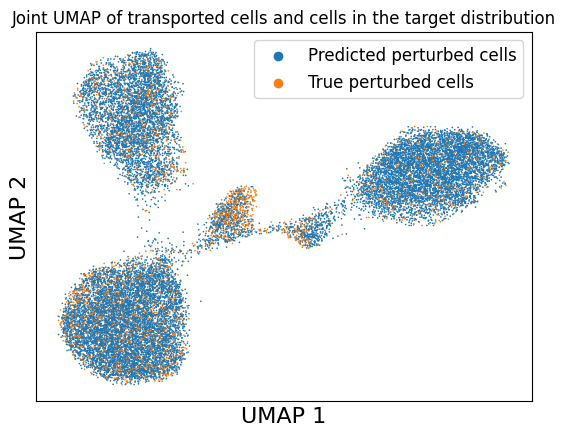

In [19]:
adata_pushed.obs["col"] = adata_pushed.obs.apply(lambda x: "Predicted perturbed cells" if x["drug"]=="control" else "True perturbed cells", axis=1)
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata_pushed.shape[0])))

fig = sc.pl.umap(adata_pushed[random_indices,:], color="col", show=False, title="Joint UMAP of transported cells and cells in the target distribution")
fig.set_xlabel("UMAP 1", fontsize=16)
fig.set_ylabel("UMAP 2", fontsize=16)
fig.legend(fontsize=12)
fig

In [20]:
from typing import Tuple, Callable, Union, List, Optional
import scipy.sparse as sp
import jax.numpy as jnp
import jax
import pandas as pd

def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  
        predicted_tgt_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 1,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None))
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        for index in range(0, len(predicted_tgt_cells), batch_size):
            _, indices = get_knn_fn(predicted_tgt_cells[index : index + batch_size], tgt_cells, k)
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(predicted_tgt_cells) - index)), min(k, len(tgt_cells)))
            )
        ri = jnp.concatenate(row_indices)
        ci = jnp.concatenate(column_indices)
        mat = np.zeros((len(ri), len(tgt_cells)))
        mat[ri,ci] = 1.0
        return mat

def aggregate_transport_matrix(adata_source, adata_target, tmat, aggregation_key = "celltype", forward = True):
    df_source = adata_source.obs[aggregation_key]
    df_target = adata_target.obs[aggregation_key]

    annotations_source = adata_source.obs[aggregation_key].cat.categories
    annotations_target = adata_target.obs[aggregation_key].cat.categories

    tm = pd.DataFrame(
        np.zeros((len(annotations_source), len(annotations_target))),
        index=annotations_source,
        columns=annotations_target,
    )
    
    for annotation_src in annotations_source:
        for annotation_tgt in annotations_target:
            tm.loc[annotation_src, annotation_tgt] = tmat[
                np.ix_((df_source == annotation_src).squeeze(), (df_target == annotation_tgt).squeeze())
            ].sum()
    return tm#.div(tm.sum(axis=int(forward)), axis=int(not forward))

In [21]:
gex_predicted = push_source[0]
target_test = target
adata_source_test = adata[adata.obs["drug"]=="control"]
adata_target_test = adata[adata.obs["drug"]=="givinostat"]

In [22]:
tm = project_transport_matrix(gex_predicted, target_test)
agg_tm = aggregate_transport_matrix(adata_source_test, adata_target_test, tm, aggregation_key="cell_type")

In [23]:
agg_tm

,A549,K562,MCF7
A549,5723.0,23.0,108.0
K562,45.0,3771.0,111.0
MCF7,116.0,154.0,7514.0


In [24]:
(agg_tm.iloc[0,0] + agg_tm.iloc[1,1] + agg_tm.iloc[2,2])/agg_tm.sum().sum()

0.9682892115001424

In [25]:
spearmanr(1-np.diag(agg_tm.div(agg_tm.sum(axis=1))), adata_red.obs[["directional_cosine_sim_variance", "cell_type"]].groupby("cell_type").mean().values)

SignificanceResult(statistic=-0.5, pvalue=0.6666666666666667)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


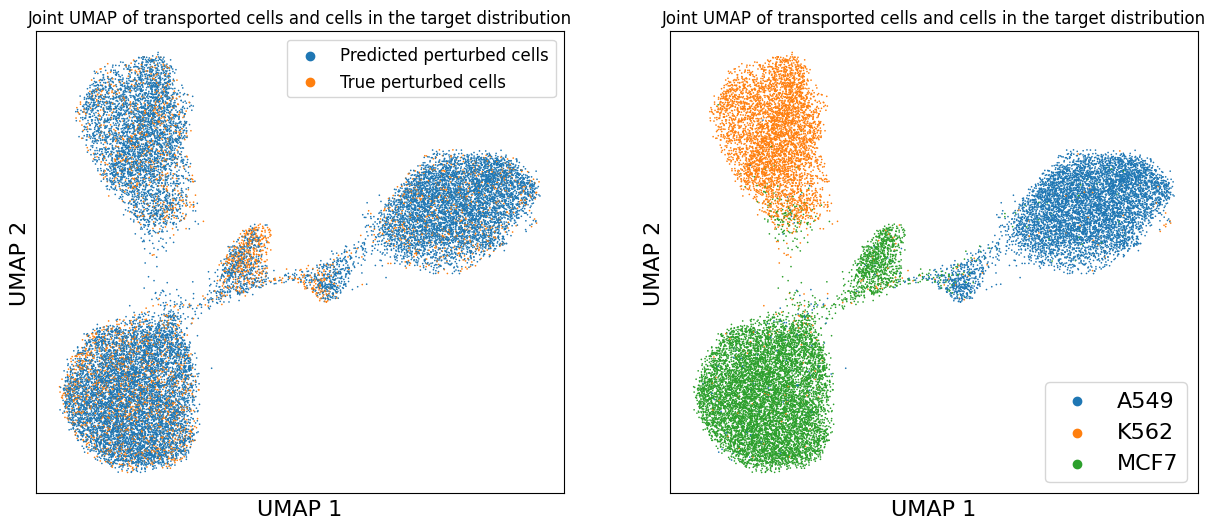

In [26]:
adata_pushed.obs["col"] = adata_pushed.obs.apply(lambda x: "Predicted perturbed cells" if x["drug"]=="control" else "True perturbed cells", axis=1)
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata_pushed.shape[0])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_pushed[random_indices,:], color="col", ax=ax1, show=False, title="Joint UMAP of transported cells and cells in the target distribution")
ax1.set_xlabel("UMAP 1", fontsize=16)
ax1.set_ylabel("UMAP 2", fontsize=16)
sc.pl.umap(adata_pushed[random_indices,:], color="cell_type", ax=ax2, show=False, title="Joint UMAP of transported cells and cells in the target distribution")
ax2.set_xlabel("UMAP 1", fontsize=16)
ax2.set_ylabel("UMAP 2", fontsize=16)
ax1.legend(fontsize=12)
ax2.legend(fontsize=16, loc="lower right")

In [27]:
adata_red.write("adata_red_givinostat_unbalanced.h5ad")
adata_pushed.write("adata_pushed_givinostat_unbalanced.h5ad")